In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest



## Configuration

Currently, our data is loaded into postgres prior to analysis using python. This method allows for scalability in the future. Although, since we are given AWS credits, we will see if it more appropriate to store data there instead of on a postgresql instance on each team members computer.

In [2]:
# pycharm cwd is project root dir 
# jupyter cwd is the location of the ipynb

config_path = '.config'
#config_path = '../.config'

data_path = 'data/'
#data_path = '../data/'

plt.rcParams["figure.figsize"] = (15,15)
config = _load_config(config_path)
sql = create_engine(config['postgres_connection_url'])

## Data Load

- unzip raw machine data to data_path
- setup an empty postgres database
- update .config with connection string as needed.
- run storage/postgres.py to import csvs

In [3]:
df = pd.read_sql('''SELECT * from sensor_readings_model1_hourly''',sql)
print(df.shape)
print(df.dtypes)

In [4]:
index_cols = ['id','TIMESTAMP','PSN']
data_cols = [c for c in df.columns if c not in index_cols]

## Feature Plots

*long running cell*

Create plots with all packages for every column with Time on x-axis.

In [ ]:
def plot_col(df, col):
    fig, ax = plt.subplots()
    for key, grp in df.groupby('PSN'):
        ax = grp.plot(ax=ax, kind='line', x='TIMESTAMP', y=col)

    ax.legend().set_visible(False)
    fig.savefig(data_path + 'feature_plots/model1/'+col+'.png')

for col in data_cols:
    plot_col(df, col)

## Feature Correlation

simple heatmap of each column

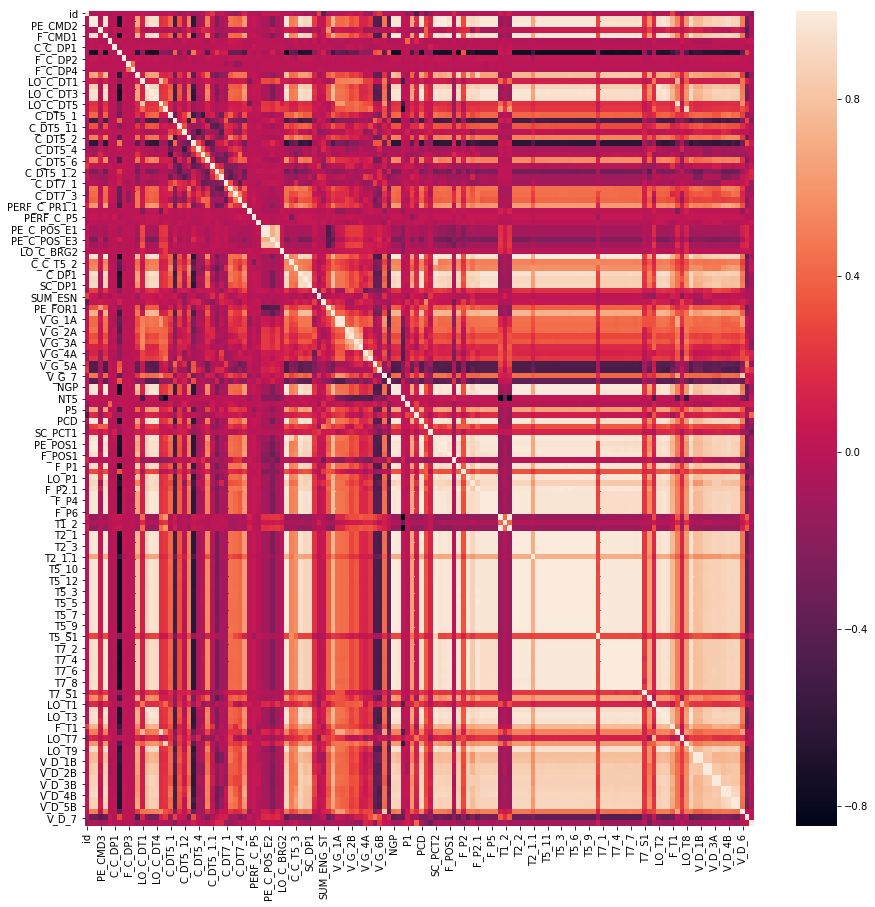

In [43]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

### Finding the highest correlating pairs of columns 

In [44]:
# https://stackoverflow.com/a/41453817

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(df[data_cols],10))

T2_3  PT2       0.999990
T2_1  PT2       0.999988
T2_2  PT2       0.999986
T2_1  T2_3      0.999969
T2_2  T2_3      0.999964
T2_1  T2_2      0.999961
T7_2  T7_9      0.999933
T7_3  T7_9      0.999925
T5_2  T5_1.1    0.999924
PCD   F_P3      0.999922
dtype: float64


We can see that of the top 10 correlating pairs, most of them are temperatures. This is as expected as temperatures should rise simultaneously. 

## Missing Values

drop null values from our dataframe

In [5]:
df_dropna = df.dropna()
missing_values = df.isnull().sum().sort_values()
print('Total Records:',len(df))
print('Complete Records:',len(df_dropna))

print('Missing Values by Col:')
print(missing_values)

Total Records: 325348
Complete Records: 73577
Missing Values by Col:
id                   0
T5_6                 0
T5_5                 0
T5_4                 0
T5_3                 0
T5_2                 0
T5_12                0
T5_11                0
T5_10                0
T5_1                 0
PT2                  0
T2_3                 0
T2_1                 0
T1_3                 0
T1_2                 0
T5_7                 0
F_P6                 0
F_P4                 0
F_P3                 0
F_P2.1               0
LO_P2                0
LO_P1                0
F_P2                 0
F_P1                 0
PE_P1                0
F_POS1               0
PE_POS2              0
PE_POS1              0
C_PCT1               0
TIMESTAMP            0
                 ...  
NGP                  0
PE_FOR1              0
V_G_4B               0
SUM_ENG_ST          46
T2_1.1             200
PE_FOR2            200
T5_8               200
T2_2               200
C_DT5_1.2          200
C_C_T5_3   

In [6]:
sparse_cols = [x for x in missing_values.index[-10:]]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]
df_clean = df[clean_data_cols].dropna()
print('Clean Records:',len(df_clean))

Clean Records: 304500


## PCA

In [8]:
def plot_component_explained_variance(data):
    pca = PCA()
    pca.fit(data)
    
    plt.plot(pca.explained_variance_[:10])
    plt.show()

def plot_3d_reduced(data, colors = None, pca=PCA(n_components=3)):
    reduced = pca.fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    z = [r[2] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z, c=colors)
    
    plt.show()
    return reduced

def plot_2d_reduced(data, colors = None, pca=PCA(n_components=2)):
    reduced = pca.fit_transform(data)
    
    x = [r[0] for r in reduced]
    y = [r[1] for r in reduced]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y, c=colors)
    
    plt.show()
    return reduced

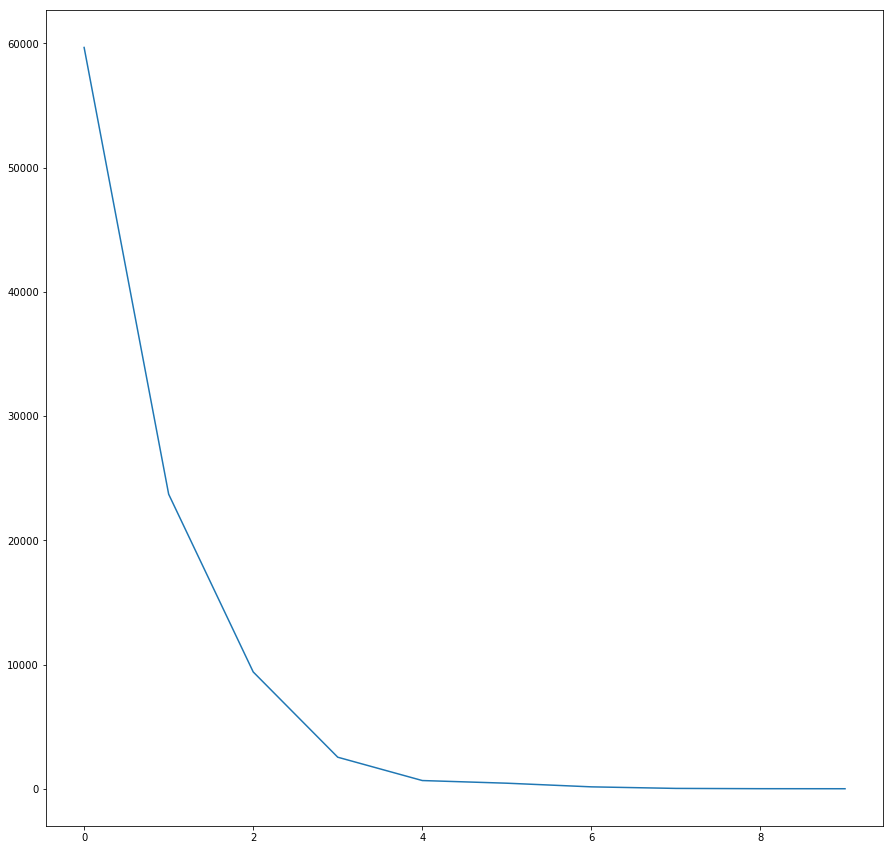

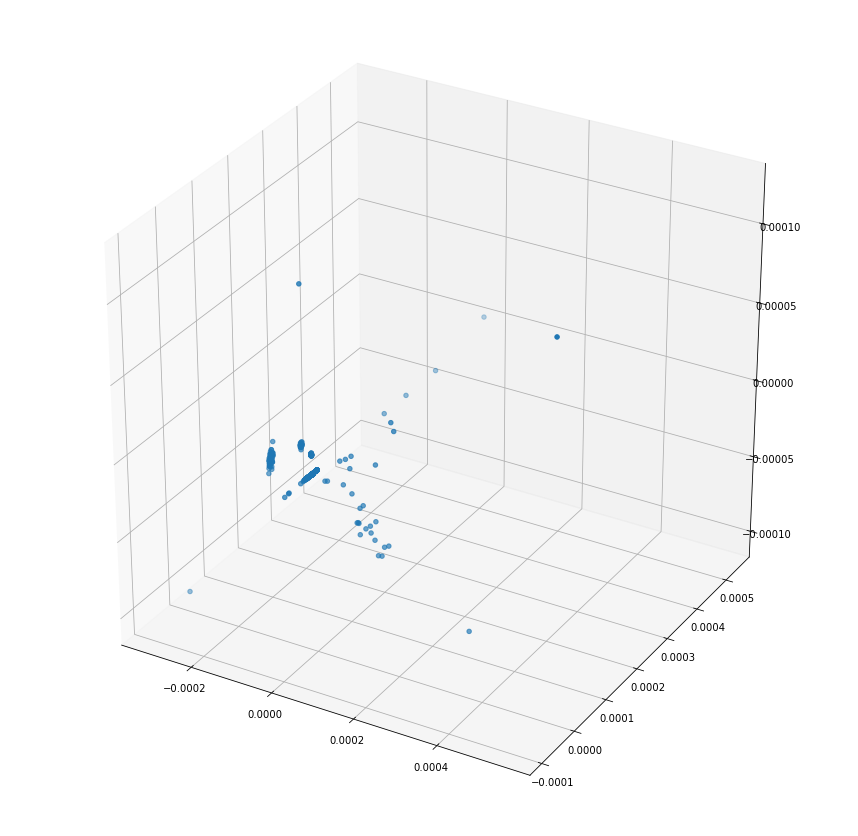

array([[  4.42228989e-07,   3.02682488e-06,  -1.12337468e-07],
       [  4.42228989e-07,   3.02682488e-06,  -1.12337468e-07],
       [  4.42229330e-07,   3.02682430e-06,  -1.12336894e-07],
       ..., 
       [ -1.15050932e-05,   2.50303451e-06,   8.98365349e-06],
       [ -1.09665788e-05,   2.52702363e-06,   8.40913308e-06],
       [ -1.14946163e-05,   2.50420878e-06,   8.62600310e-06]])

In [26]:
plot_component_explained_variance(df_dropna[data_cols])
#plot_2d_reduced(df_dropna[data_cols])
plot_3d_reduced(df_dropna[data_cols][:10000], pca=KernelPCA(n_components=3, kernel='sigmoid'))

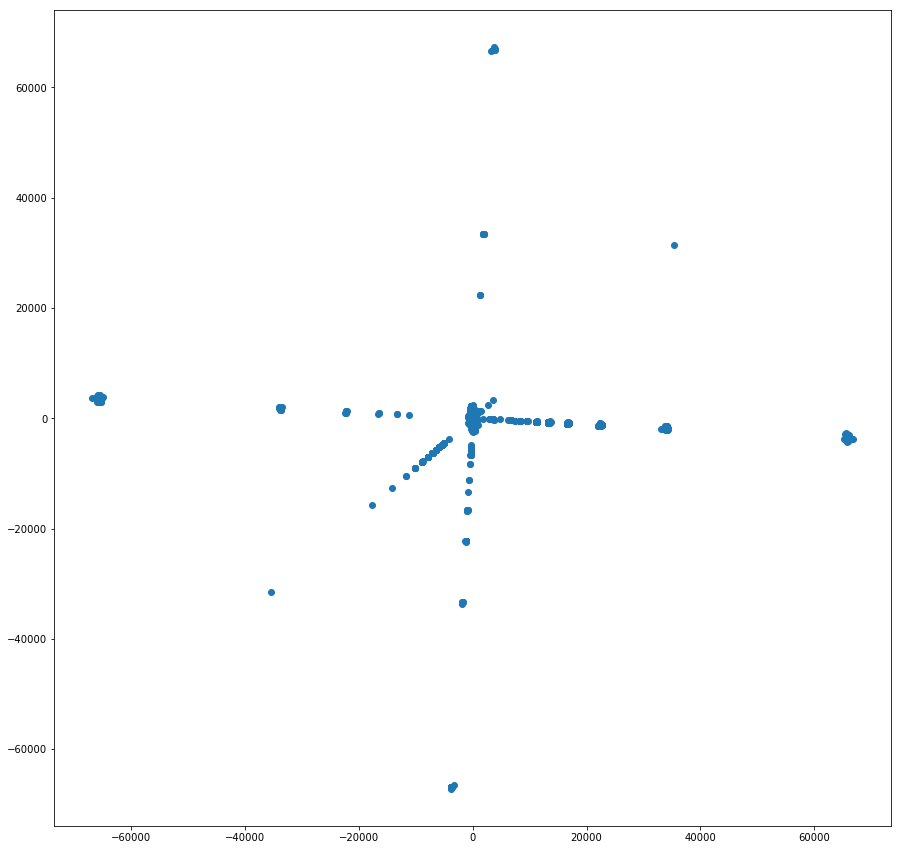

In [44]:
#plot_component_explained_variance(df_clean)
#reduced_3d_clean_data = plot_3d_reduced(df_clean)
reduced_2d_clean_data = plot_2d_reduced(df_clean[clean_data_cols])

In [31]:
colors = []
anomaly_labels = []

for i,d in enumerate(reduced_2d_clean_data):
    dist = np.linalg.norm(d-np.array((0,0)))
    if np.abs(dist) > 5000:
        anomaly_labels.append(-1)
    else:
        anomaly_labels.append(1)
        
df_clean['anomaly'] = anomaly_labels

In [41]:
for g,d in df_clean[['PSN','TIMESTAMP','anomaly']].groupby('PSN'):
    plt.plot()
sns.tsplot(, time='TIMESTAMP', condition='PSN', value='anomaly')
plt.show()

/home/jared/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


MemoryError: 

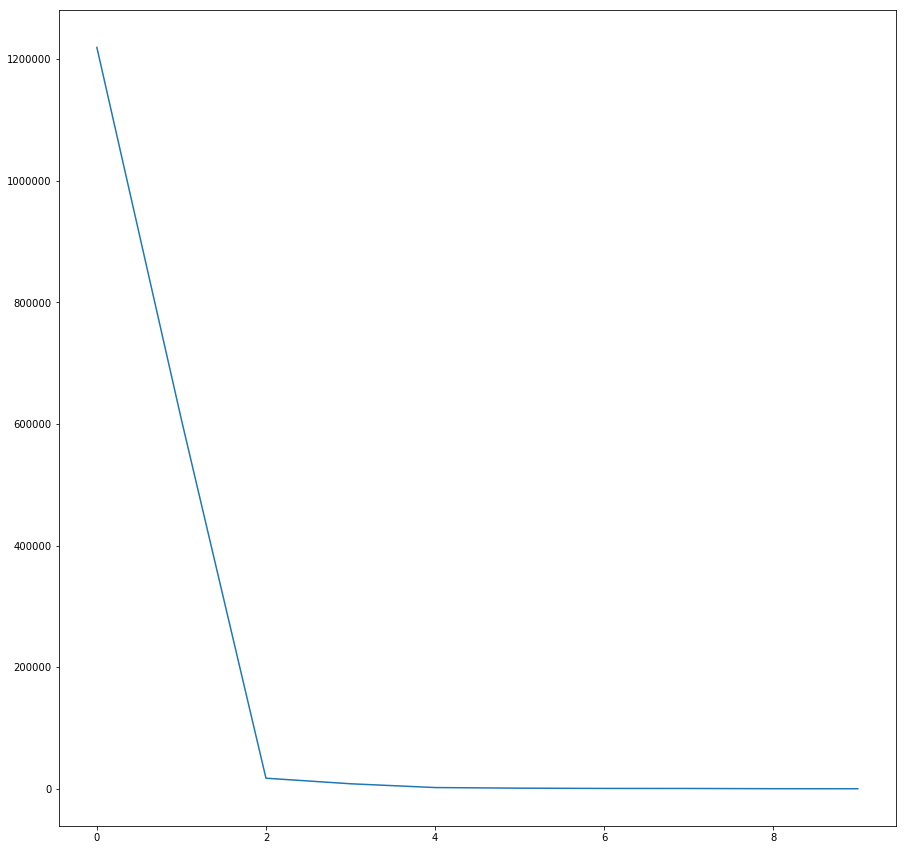

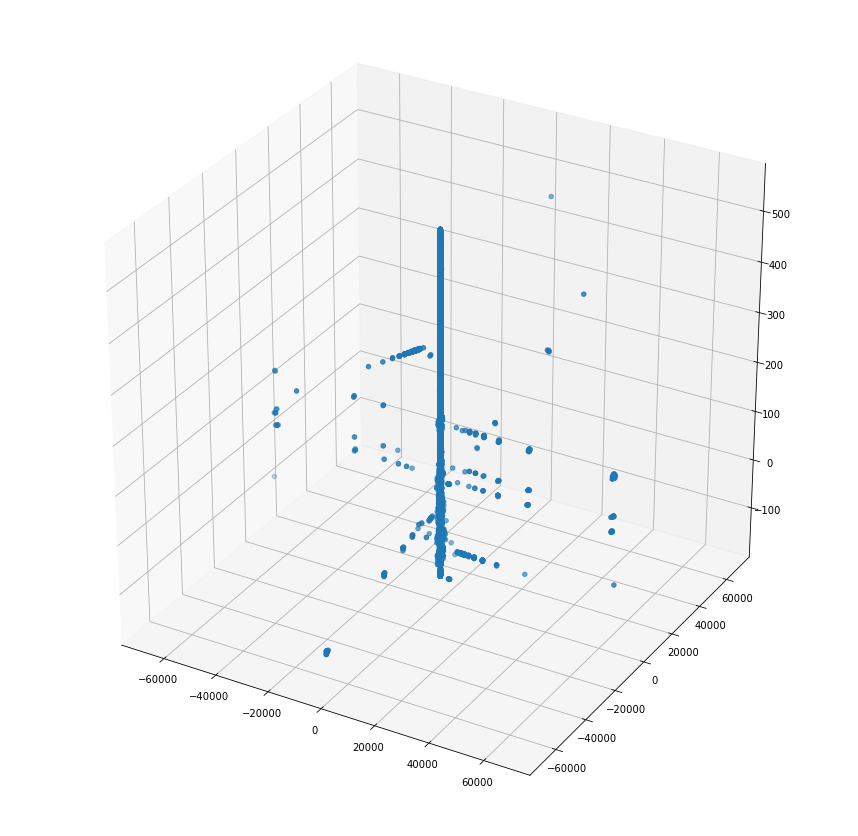

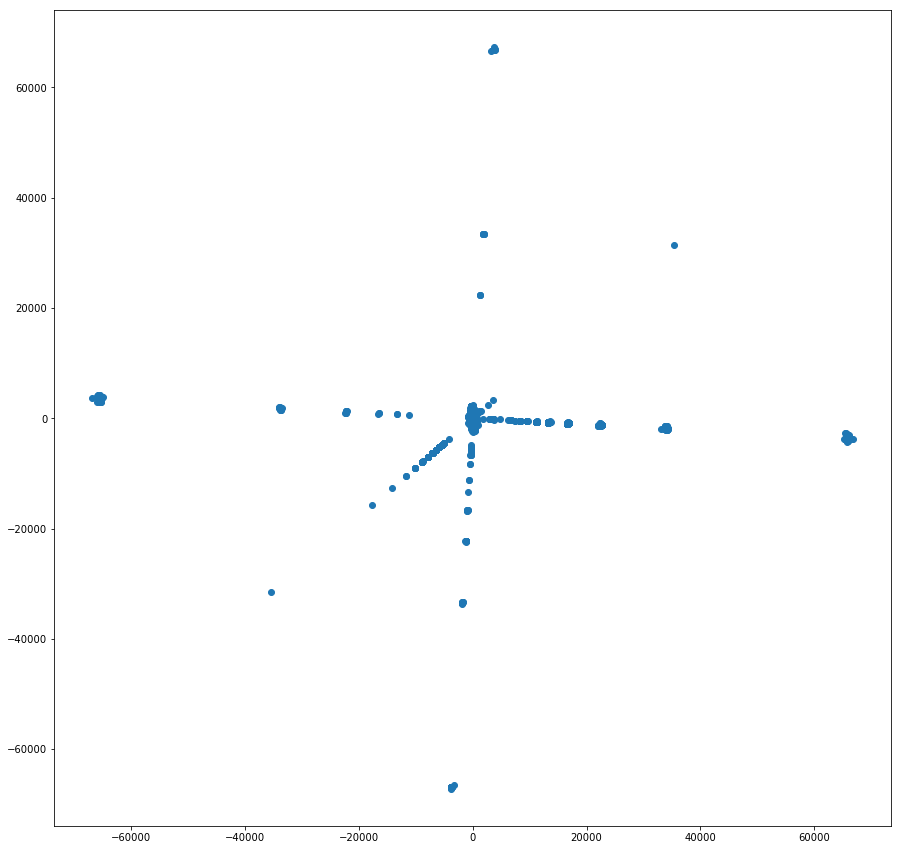

In [19]:
df_interpolate_na = df_clean.interpolate(method='linear', axis=0).ffill().bfill()

plot_component_explained_variance(df_interpolate_na)
reduced_3d_interpolated = plot_3d_reduced(df_interpolate_na)
reduced_2d_interpolated = plot_2d_reduced(df_interpolate_na)

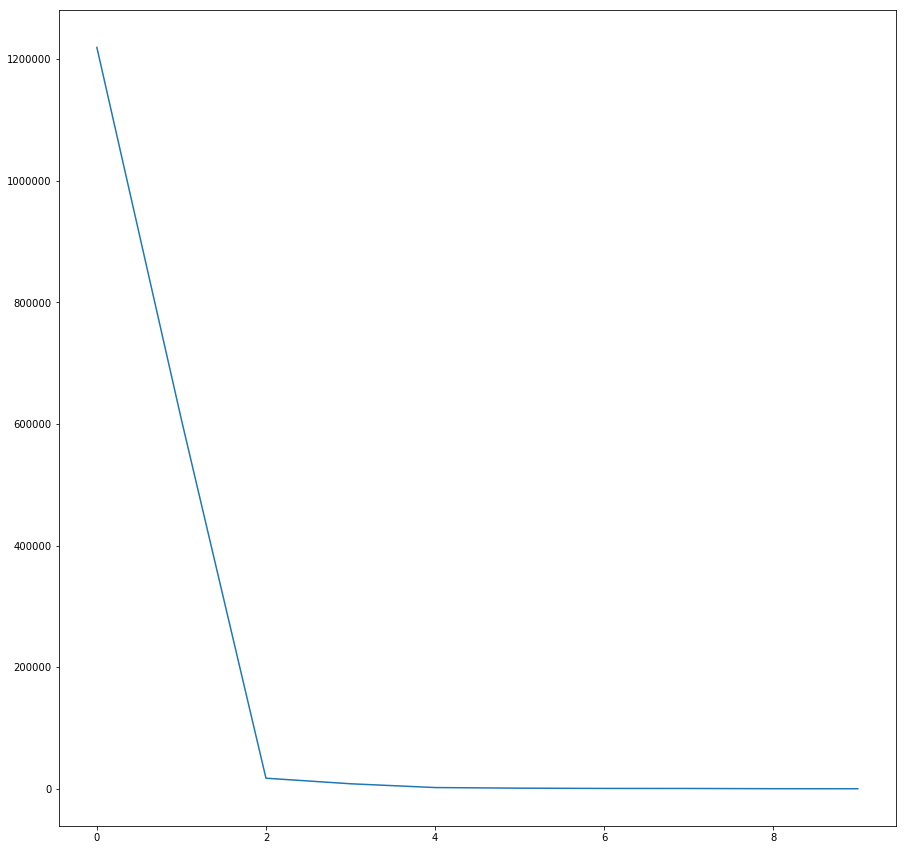

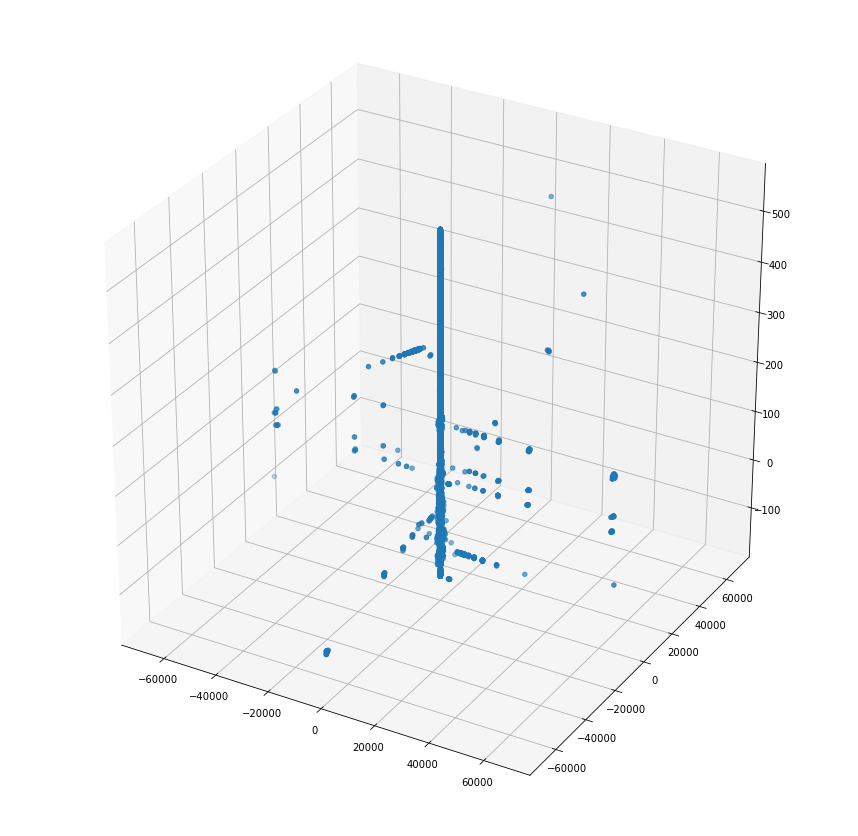

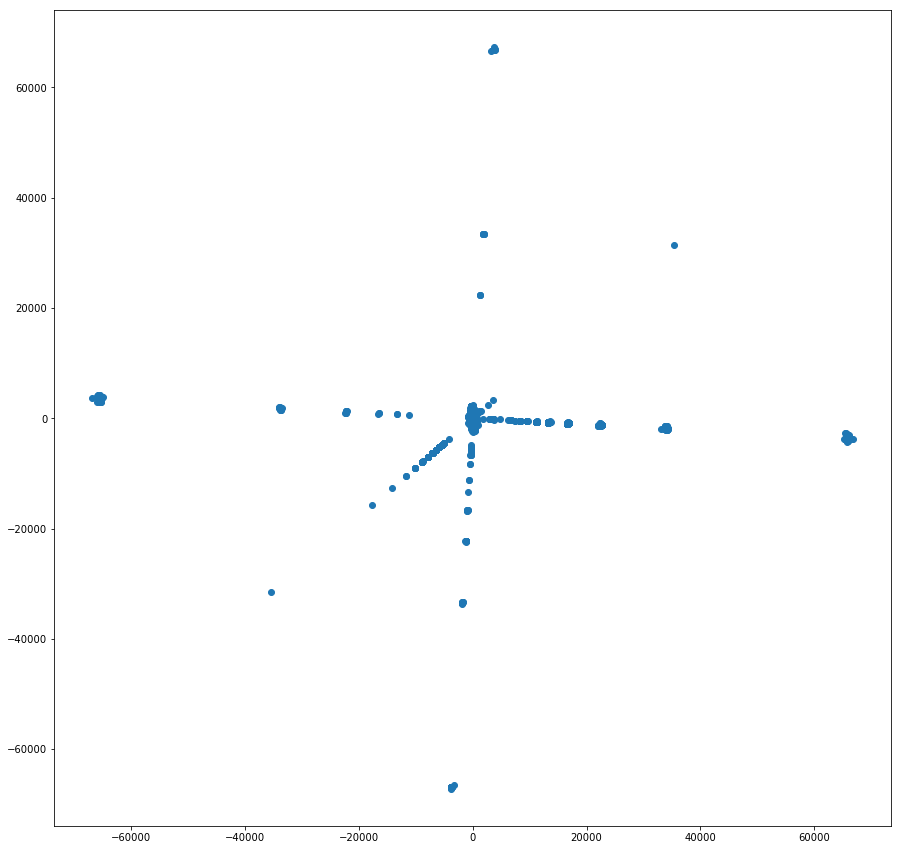

In [20]:
df_avg_na = df_clean.apply(lambda x: x.fillna(x.mean()),axis=0)

plot_component_explained_variance(df_avg_na)
reduced_3d_avg = plot_3d_reduced(df_avg_na)
reduced_2d_avg = plot_2d_reduced(df_avg_na)

In [7]:
df_clean_id = df[index_cols+clean_data_cols].dropna()
df_clean_id.head()

,id,TIMESTAMP,PSN,PE_CMD1,PE_CMD2,PE_CMD3,F_CMD1,PERF_C_PR1,F_C_DP1,F_C_DP2,...,V_D_2A,V_D_2B,V_D_3A,V_D_3B,V_D_4A,V_D_4B,V_D_5A,V_D_5B,V_D_6,V_D_7
0,1,2015-12-05 00:00:00.000000,24.0,0.0,0.0,0.0,0.0,0.049725,91.214001,-0.005675,...,0.027273,0.027273,0.027273,0.027273,0.013636,0.013636,0.013636,0.009091,-2.000000,0.150000
1,2,2015-12-05 00:59:59.999996,24.0,0.0,0.0,0.0,0.0,0.049725,91.258002,0.000000,...,0.027273,0.027273,0.027273,0.027273,0.013636,0.013636,0.013636,0.009091,-1.950000,0.150000
2,3,2015-12-05 02:00:00.000003,24.0,0.0,0.0,0.0,0.0,0.049645,91.282001,-0.022700,...,0.027273,0.027273,0.027273,0.027273,0.013636,0.013636,0.013636,0.009091,-1.916667,0.166667
3,4,2015-12-05 03:00:00.000000,24.0,0.0,0.0,0.0,0.0,0.049630,91.294000,-0.039725,...,0.027273,0.027273,0.027273,0.027273,0.013636,0.013636,0.013636,0.009091,-1.883333,0.166667
4,5,2015-12-05 03:59:59.999996,24.0,0.0,0.0,0.0,0.0,0.049710,91.285999,0.000000,...,0.027273,0.027273,0.027273,0.027273,0.018182,0.018182,0.013636,0.009091,-1.833333,0.166667


In [8]:
df_clean_id = df_clean_id.groupby('PSN')

In [26]:
df_clean_id['id'].agg(['count']).sort_values(by='count')

In [ ]:
for name,data in df_clean_id:
    plot_2d_reduced(data[clean_data_cols])

### Isolation Forest

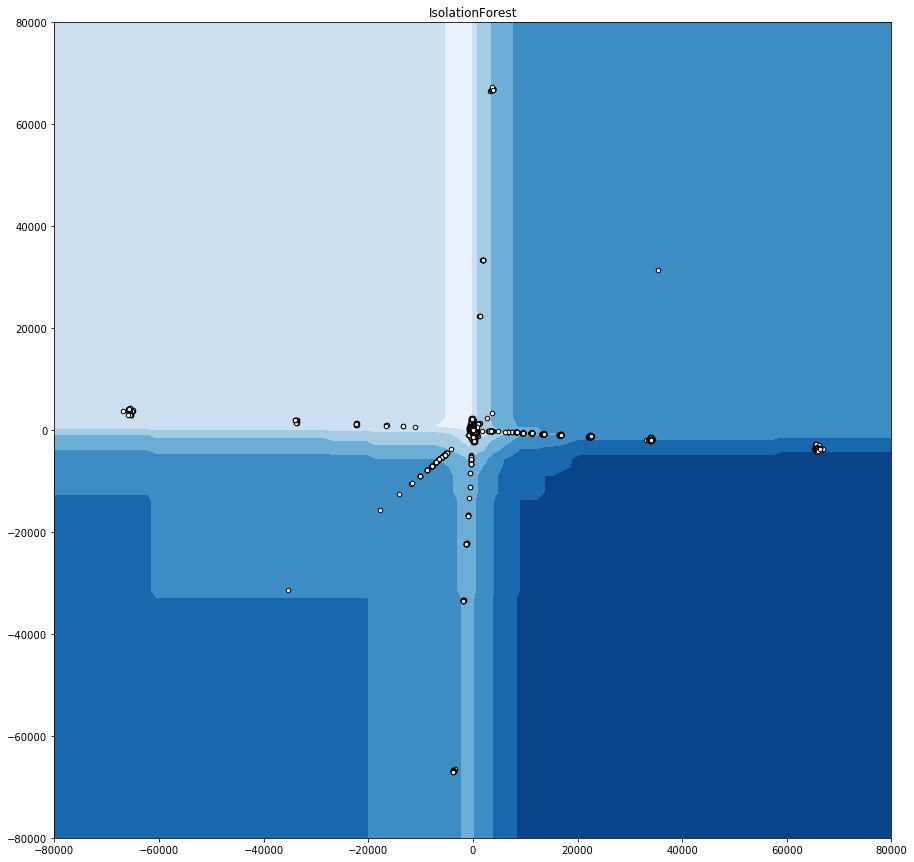

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

print(X_train.shape)

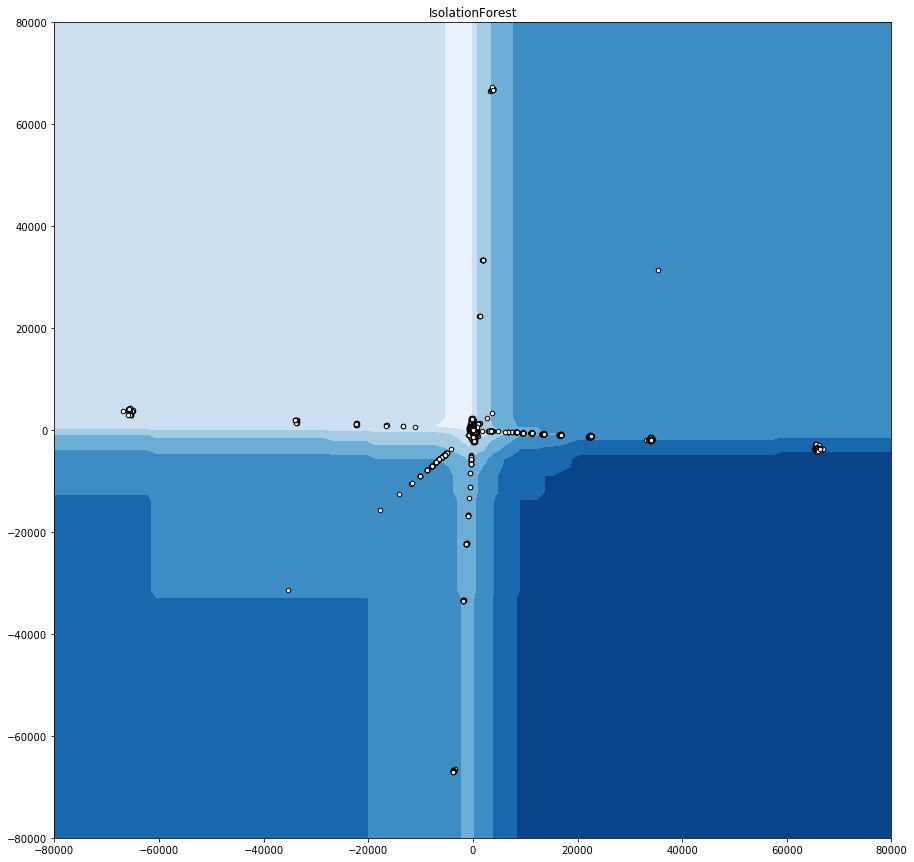

In [15]:
def plot_isolation_forest(data):
    X_train = PCA(n_components=2).fit_transform(data)
    
    # fit the model
    clf = IsolationForest()
    clf.fit(X_train)
    
    y_pred_train = clf.predict(X_train)
   
    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-80000, 80000, 100), np.linspace(-80000, 80000, 100))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                     s=20, edgecolor='k')
    plt.axis('tight')
    plt.show()

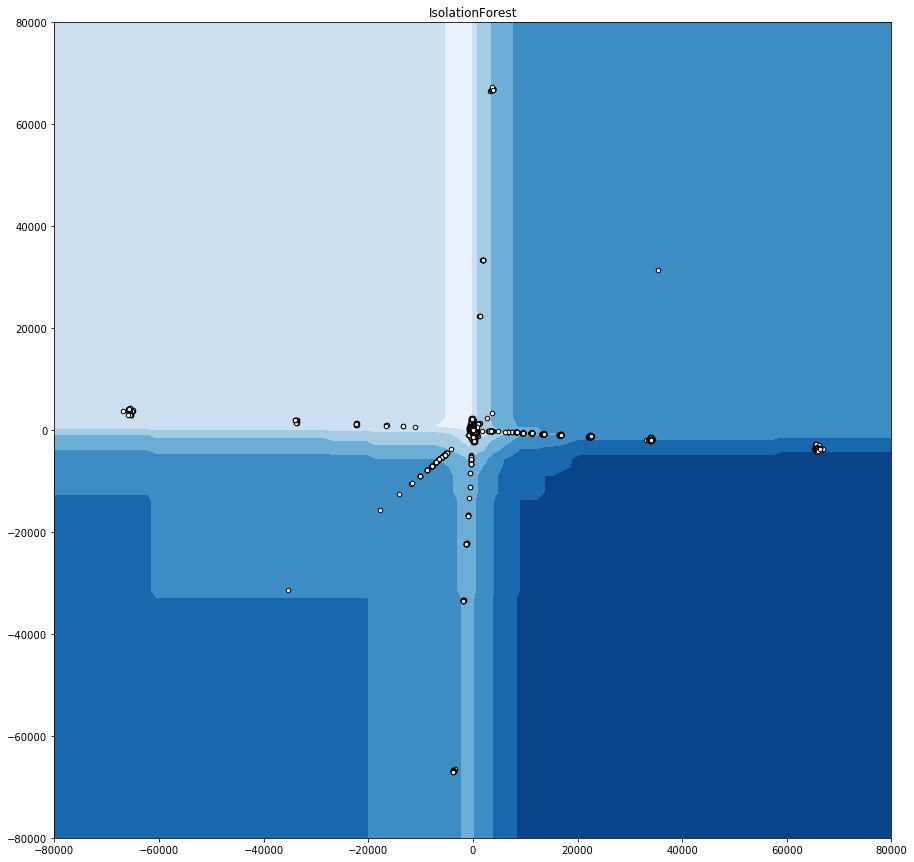

In [16]:
plot_isolation_forest(df_clean)

## Analysis 2

In [ ]:
index_cols = ['id','TIMESTAMP','PSN']
data_cols = [c for c in df.columns if c not in index_cols]

In [28]:
df_15 = df[df['PSN'] == 15].sort_values(by='TIMESTAMP')
df_15['TIMESTAMP'].head()

75403   2015-12-05 00:00:00.000000
75404   2015-12-05 00:59:59.999996
75405   2015-12-05 02:00:00.000003
75406   2015-12-05 03:00:00.000000
75407   2015-12-05 03:59:59.999996
Name: TIMESTAMP, dtype: datetime64[ns]

In [42]:
def check_null(s):
    return s.isnull()

def unchanging_values(s, threshold=5):
    pass

def normal_dist(s, threshold=2.5):
    std = s.std()    
    m = s.mean()
    upper = m + (threshold * std)
    lower = m - (threshold * std)
    return s.apply(lambda x: (x > upper | (x < m - lower)))


def static_threshold(s, min_threshold, max_threshold):
    return s.apply(lambda x: (x > max_threshold) | (x < min_threshold))

Checking for nulls in data

In [43]:
sparse = []
for c in data_cols:
    sparse.append(
        check_null(df_15[c]) |
        static_threshold(df_15[c], 0, .9))

In [44]:
sparse_df = pd.DataFrame(sparse).T
sparse_df.head()

,PE_CMD1,PE_CMD2,PE_CMD3,F_CMD1,PERF_C_PR1,C_C_DP1,F_C_DP1,F_C_DP2,F_C_DP3,F_C_DP4,...,V_D_2A,V_D_2B,V_D_3A,V_D_3B,V_D_4A,V_D_4B,V_D_5A,V_D_5B,V_D_6,V_D_7
75403,False,False,False,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,True,True
75404,False,True,False,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,True,True
75405,False,True,False,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,True,True
75406,False,True,False,False,True,False,True,False,True,True,...,False,False,False,False,False,False,False,False,True,True
75407,False,True,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True


In [45]:
sparse_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29c1aa85c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f29baecf048>]], dtype=object)

Counts of values in each column after removing nulls

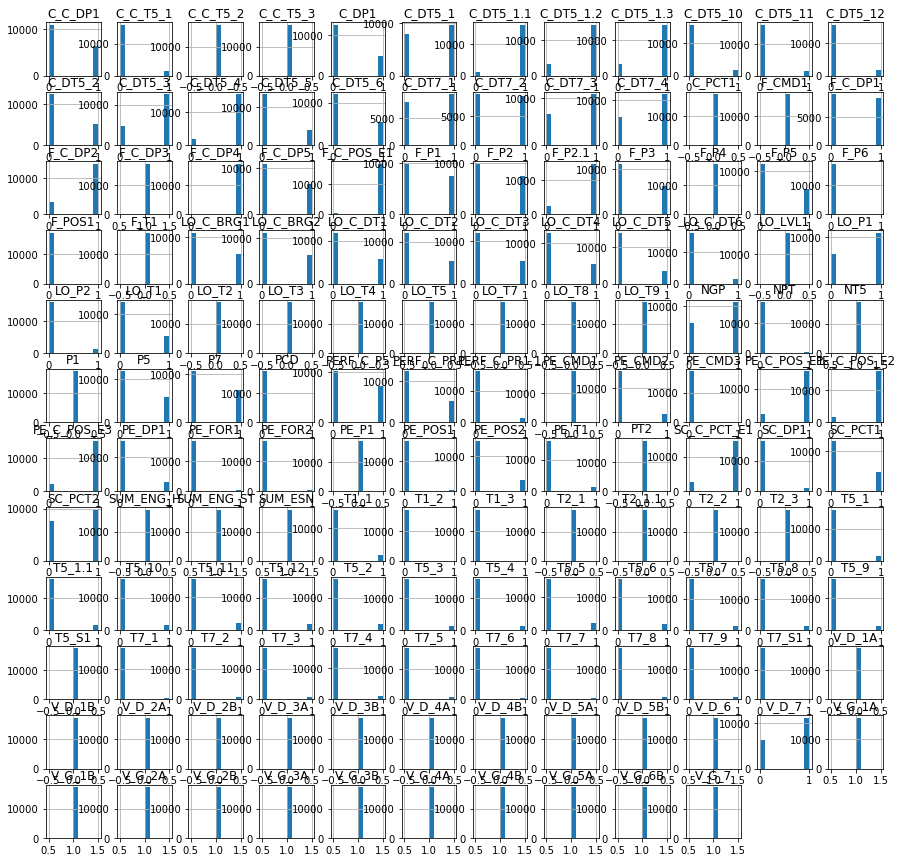

In [46]:
plt.show()